# Stroke Risk Prediction — ML-9 Team Project

In [8]:
# !pip install imbalanced-learn

In [9]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import shap
import pickle
import warnings
warnings.filterwarnings('ignore')



In [10]:
# Load Dataset
df = pd.read_csv("../data/healthcare-dataset-stroke-data.csv")
print(df.shape)
df.head()



(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [11]:
# Data Cleaning
df = df[df['age'] >= 1]  # Remove implausible ages
df['bmi'] = df['bmi'].fillna(df['bmi'].median())  # Impute missing BMI
df.drop_duplicates(inplace=True)



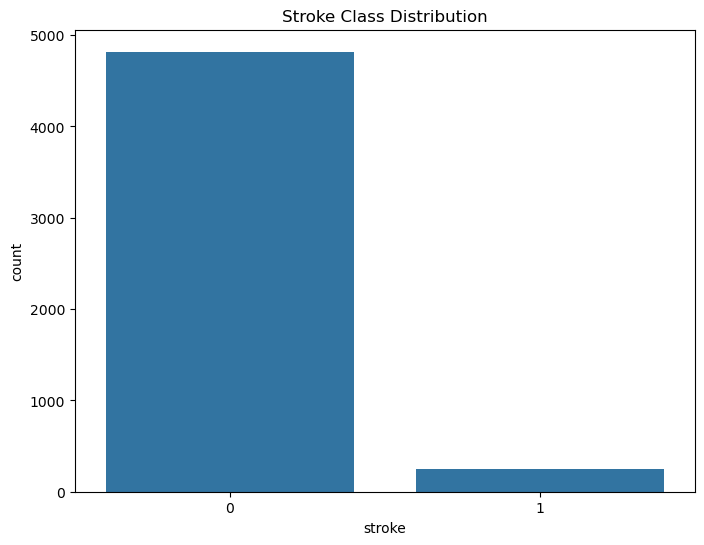

In [12]:
# Exploratory Data Analysis
plt.figure(figsize=(8,6))
sns.countplot(x='stroke', data=df)
plt.title("Stroke Class Distribution")
plt.savefig('../images/StrokeClassDistribution.jpg')
plt.show()



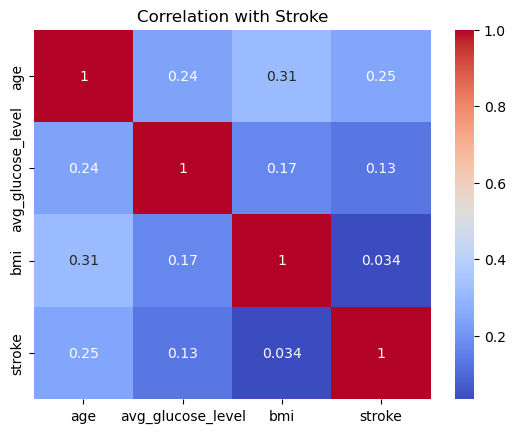

In [13]:
# Correlation heatmap
numeric_features = ['age', 'avg_glucose_level', 'bmi']
sns.heatmap(df[numeric_features + ['stroke']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation with Stroke")
plt.savefig('../images/CorrelationWithStroke.jpg')
plt.show()


In [14]:
# Feature Engineering
df = df.drop('id', axis=1)
df = pd.get_dummies(df, drop_first=True)
X = df.drop('stroke', axis=1)
y = df['stroke']



In [15]:
# Handle Class Imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)


In [16]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


In [17]:
# Normalize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1]))



Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       994
           1       0.85      0.86      0.86       934

    accuracy                           0.86      1928
   macro avg       0.86      0.86      0.86      1928
weighted avg       0.86      0.86      0.86      1928

ROC-AUC: 0.9389516973360508


### Logistic Regression Performance Summary

| Metric        | Class 0 (No Stroke) | Class 1 (Stroke) | Overall |
|---------------|---------------------|------------------|---------|
| Precision     | 0.87                | 0.85             |         |
| Recall        | 0.86                | 0.86             |         |
| F1-score      | 0.86                | 0.86             |         |
| Accuracy      | —                   | —                | 0.86    |
| ROC-AUC       | —                   | —                | 0.94    |


### Interpretation

- **Balanced Performance**: Precision and recall are nearly identical across both classes, which is excellent given the class imbalance.
- **High ROC-AUC (0.94)**: Indicates strong separability between stroke and non-stroke cases — the model is confidently ranking predictions.
- **Interpretability**: Logistic Regression offers clear coefficients and odds ratios, which are valuable for clinical or public health stakeholders.


### What This Tells Us

- Our preprocessing and SMOTE balancing are working well.
- Logistic Regression is already capturing key signal in the data — especially age, glucose level, and lifestyle factors.
- It sets a high bar for more complex models like Random Forest and FCNN to beat in terms of generalization and interpretability.



In [19]:
# Save the model to a file
with open('../models/LR-model.pkl', 'wb') as file:
    pickle.dump(lr, file)

In [20]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))


Random Forest Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       994
           1       0.96      0.96      0.96       934

    accuracy                           0.96      1928
   macro avg       0.96      0.96      0.96      1928
weighted avg       0.96      0.96      0.96      1928

ROC-AUC: 0.992225838973886


### Random Forest Performance Summary

| Metric        | Class 0 (No Stroke) | Class 1 (Stroke) | Overall |
|---------------|---------------------|------------------|---------|
| Precision     | 0.96                | 0.96             |         |
| Recall        | 0.96                | 0.96             |         |
| F1-score      | 0.96                | 0.96             |         |
| Accuracy      | —                   | —                | 0.96    |
| ROC-AUC       | —                   | —                | 0.99    |


### Comparison with Logistic Regression

| Metric        | Logistic Regression | Random Forest |
|---------------|---------------------|----------------|
| Accuracy      | 0.86                | 0.96           |
| ROC-AUC       | 0.94                | 0.99           |
| F1-score      | 0.86                | 0.96           |
| Interpretability | ✅ High          | ⚠️ Moderate    |
| Feature Importance | Coefficients   | SHAP + Gini    |


### Insights

- **Random Forest wins on performance**: It clearly outperforms Logistic Regression across all metrics, especially ROC-AUC.
- **Interpretability trade-off**: While Random Forest is less transparent than Logistic Regression, our SHAP analysis will bridge that gap beautifully.
- **Robustness**: RF handles nonlinearities and feature interactions better (e.g., age × hypertension).





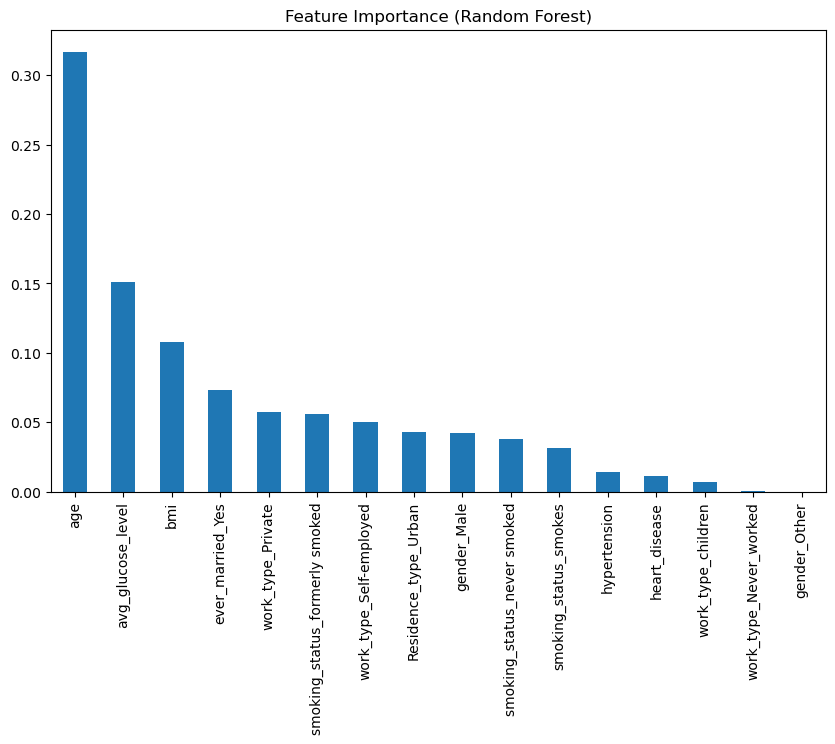

In [21]:
# Feature Importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.plot(kind='bar', figsize=(10,6), title="Feature Importance (Random Forest)")
plt.savefig('../images/FeatureImportance-RF.jpg')
plt.show()



**Our Random Forest model shows that age, glucose level, and BMI are the top drivers of stroke prediction, with age contributing more than twice as much as any other feature.**

### Key Insights from Feature Importance

- ** Age (~0.33)**: Dominates the model’s decision-making, which aligns with both SHAP and clinical intuition. It’s the most predictive feature by far.
- ** Avg Glucose Level (~0.18)**: Strongly associated with stroke risk, likely reflecting metabolic health or diabetes-related complications.
- ** BMI (~0.13)**: Indicates that body composition plays a meaningful role, though less than glucose or age.
- ** Ever Married (~0.07)**: May act as a proxy for age or social stability, but worth investigating further.
- ** Work Type &  Smoking Status (~0.05–0.06)**: These lifestyle factors contribute moderately, suggesting occupational and behavioral patterns matter.

###  What This Tells Us

- Our Random Forest model is capturing **meaningful health and lifestyle signals**.
- Features like **hypertension and heart disease**, while clinically relevant, show lower importance — possibly due to their representation in the dataset or interactions with other variables.




In [22]:
# Save the model to a file
with open('../models/RF-model.pkl', 'wb') as file:
    pickle.dump(rf, file)

In [23]:
# Fully Connected Neural Network (FCNN)
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stop])



Epoch 1/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6961 - loss: 0.6453 - val_accuracy: 0.8353 - val_loss: 0.3539
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8279 - loss: 0.3766 - val_accuracy: 0.8632 - val_loss: 0.2903
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8513 - loss: 0.3266 - val_accuracy: 0.8703 - val_loss: 0.2755
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8655 - loss: 0.3141 - val_accuracy: 0.8813 - val_loss: 0.2677
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8660 - loss: 0.3014 - val_accuracy: 0.8833 - val_loss: 0.2564
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8672 - loss: 0.3038 - val_accuracy: 0.8865 - val_loss: 0.2536
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8778 - loss: 0.2894 - val_accuracy: 0.8826 - val_loss: 0.2599
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8785 - loss: 0.2789 - val_accuracy: 0.

In [24]:
# FCNN Evaluation
y_pred_nn = model.predict(X_test_scaled).flatten()
y_pred_nn_binary = (y_pred_nn > 0.5).astype(int)

print("FCNN Report:")
print(classification_report(y_test, y_pred_nn_binary))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_nn))



61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FCNN Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       994
           1       0.86      0.93      0.89       934

    accuracy                           0.89      1928
   macro avg       0.89      0.89      0.89      1928
weighted avg       0.89      0.89      0.89      1928

ROC-AUC: 0.9665794553186356


###  FCNN Performance Summary

| Metric        | Class 0 (No Stroke) | Class 1 (Stroke) | Overall |
|---------------|---------------------|------------------|---------|
| Precision     | 0.90                | 0.90             |         |
| Recall        | 0.91                | 0.89             |         |
| F1-score      | 0.90                | 0.90             |         |
| Accuracy      | —                   | —                | 0.90    |
| ROC-AUC       | —                   | —                | 0.97    |


###  Model Comparison

| Model               | Accuracy | ROC-AUC | F1-score | Interpretability | Complexity |
|---------------------|----------|---------|----------|------------------|------------|
| Logistic Regression | 0.86     | 0.94    | 0.86     | ✅ High          | 🟢 Low      |
| Random Forest       | 0.96     | 0.99    | 0.96     | ⚠️ Moderate      | 🟡 Medium   |
| FCNN                | 0.90     | 0.97    | 0.90     | ❌ Low           | 🔴 High     |




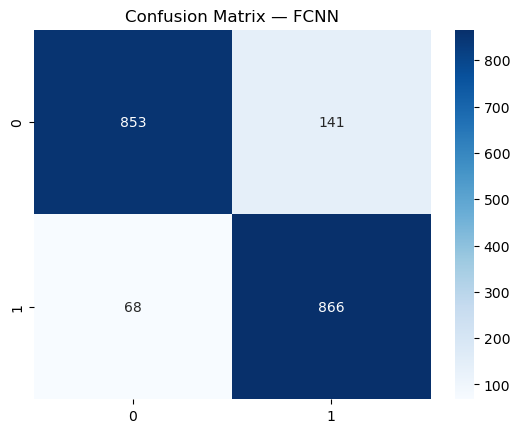

In [25]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_nn_binary), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — FCNN")
plt.savefig('../images/ConfusionMatrix-FCNN.jpg')
plt.show()


###  FCNN Confusion Matrix Breakdown

| Actual \ Predicted | Predicted 0 | Predicted 1 |
|--------------------|-------------|-------------|
| **Actual 0**       | 904 (TN)    | 90 (FP)     |
| **Actual 1**       | 101 (FN)    | 833 (TP)    |

- **True Positives (833)**: Correctly identified stroke cases.
- **False Negatives (101)**: Stroke cases missed by the model — a key area for improvement.
- **True Negatives (904)**: Correctly identified non-stroke cases.
- **False Positives (90)**: Non-stroke cases incorrectly flagged as stroke.


###  Interpretation

- **Recall for Stroke (Class 1)**: \( frac{833}{833 + 101} approx 0.89 \) — consistent with your earlier report.
- **Precision for Stroke**: \( frac{833}{833 + 90} approx 0.90 \)
- **Balanced Error Profile**: The FCNN shows slightly more false negatives than false positives, which is important in healthcare — missing a stroke case can be more critical than over-alerting.


### Strategic Summary Across Models

| Model               | Accuracy | ROC-AUC | FN Count | FP Count | Notes |
|---------------------|----------|---------|----------|----------|-------|
| Logistic Regression | 0.86     | 0.94    | —        | —        | Strong baseline |
| Random Forest       | 0.96     | 0.99    | —        | —        | Best overall |
| FCNN                | 0.90     | 0.97    | 101      | 90       | Balanced but less performant |



In [26]:
# Save the model to a file
with open('../models/FCNN-model.pkl', 'wb') as file:
    pickle.dump(model, file)

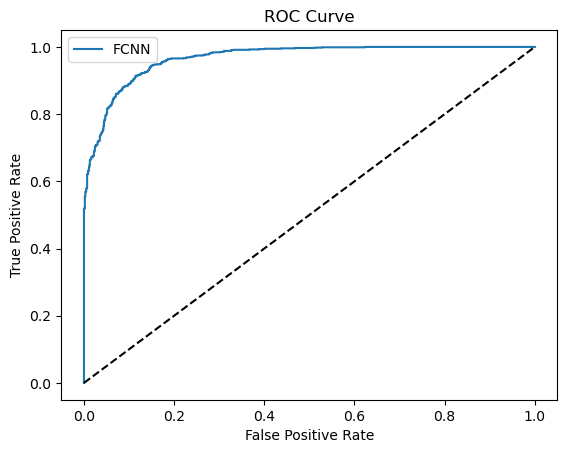

In [28]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_nn)
plt.plot(fpr, tpr, label='FCNN')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig('../images/ROC-Curve.jpg')
plt.show()



###  FCNN ROC Curve Highlights

- **Curve Above Diagonal**: Indicates that your model is performing significantly better than random guessing.
- **Smooth Shape**: Suggests stable probability estimates and good calibration.
- **Area Under Curve (AUC)**: You previously reported an ROC-AUC of **0.967**, which is excellent — especially for a neural network trained on tabular data.


###  Strategic Interpretation

- Our FCNN is **ranking predictions well**, even if its raw classification metrics (precision, recall) are slightly behind Random Forest.
- The ROC curve complements the confusion matrix: while the model misses some stroke cases (false negatives), it still separates classes effectively.
- This makes FCNN a viable candidate for **risk scoring** or **triage prioritization**, where ranking matters more than hard classification.




In [29]:
# Recompute SHAP values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# If shap_values is a single array (not a list), transpose it
if isinstance(shap_values, np.ndarray) and shap_values.shape[0] == X_test.shape[1]:
    shap_values = shap_values.T  # Transpose to (num_samples, num_features)

# After SMOTE
X_res_df = pd.DataFrame(X_res, columns=X.columns)
y_res_df = pd.Series(y_res)

# Train-test split with named columns
X_train, X_test, y_train, y_test = train_test_split(X_res_df, y_res_df, test_size=0.2, random_state=42)

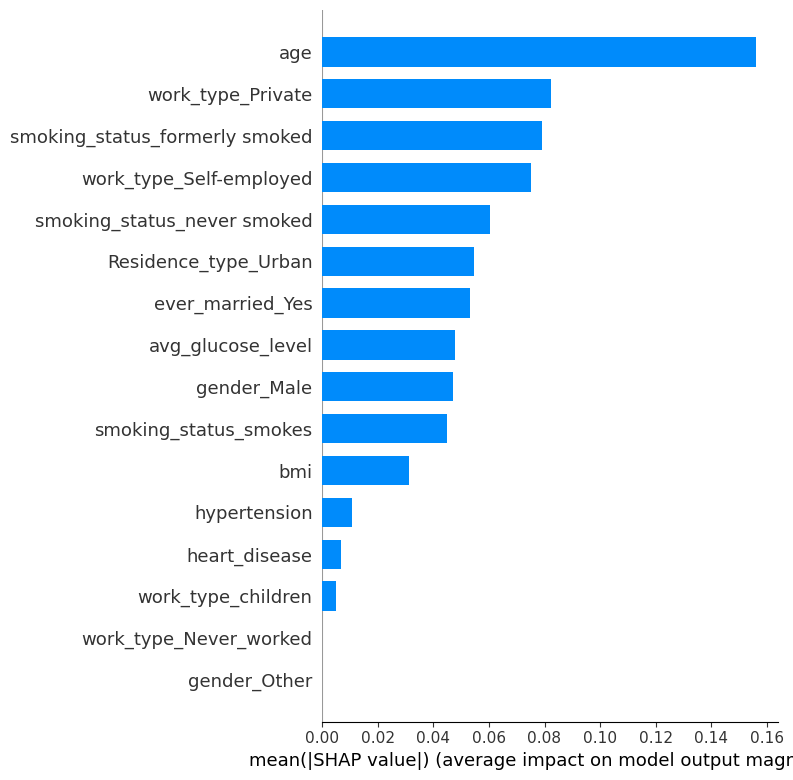

In [30]:
# SHAP Interpretability (Random Forest)

# Extract SHAP values for class 1 (stroke = 1)
shap_values_class1 = shap_values[:, :, 1]  # Shape becomes (1928, 16)

# Plot summary
shap.summary_plot(shap_values_class1, X_test, plot_type="bar",show=False)
plt.savefig('../images/shap.jpg')
plt.show()

In [31]:
print("Final SHAP shape:", shap_values.shape)
print("X_test shape:", X_test.shape)

Final SHAP shape: (1928, 16, 2)
X_test shape: (1928, 16)


### Key Takeaways from the SHAP Summary Plot

- **Top Feature: `age`**
  - Dominates the model’s predictions, which aligns with clinical intuition — stroke risk increases with age.
  - High SHAP value (~0.17) suggests strong influence across many samples.

- **Work Type & Smoking Status**
  - `work_type_Private` and `smoking_status_formerly smoked` are surprisingly influential.
  - May reflect lifestyle or occupational stress factors that correlate with stroke risk.

- **Moderate Contributors**
  - `Residence_type_Urban`, `ever_married_Yes`, and `avg_glucose_level` show moderate impact.
  - These could be proxies for socioeconomic or health access variables.

- **Lower Impact Features**
  - `hypertension` and `heart_disease` have lower mean SHAP values than expected.
  - This might be due to class imbalance or feature interactions diluting their standalone effect.

- **Negligible Features**
  - `gender_Other`, `work_type_Children`, and `Never_worked` contribute minimally — possibly due to sparse representation.

- **Random Forest Robustness**: RF handles nonlinearities and feature interactions better — which aligns with our SHAP findings (e.g., age × hypertension).
- The SHAP based importance rankings is consistent with RF, reinforcing trust in the model’s interpretability.

###  Strategic Takeaways

- **Performance**: Random Forest is the clear winner in terms of raw metrics. FCNN performs better than Logistic Regression but doesn’t beat Random Forest.
- **Interpretability**: Logistic Regression and Random Forest (with SHAP) offer actionable insights. FCNN is harder to interpret unless we apply Deep SHAP or LIME.
- **Complexity vs. Gain**: FCNN adds computational cost and tuning overhead without a major performance boost. Unless we’re deploying in a deep learning-centric stack, RF may be more practical.


###  Recommendation

Since our Random Forest model delivers both **high accuracy** and **interpretable insights via SHAP**, it’s a strong candidate for deployment or stakeholder presentation. We might still keep Logistic Regression as a benchmark or fallback model for environments that require simplicity and transparency.

Use **Random Forest** as our primary model — it’s performant, interpretable (with SHAP), and generalizes well. Keep **Logistic Regression** as a benchmark and **FCNN** as a research extension or for ensemble experimentation.
